# Data Check Notebook

This notebook compares the data from the replication package (_p) to newly retrieved sources from the publicly available FuelWatch data sources.

Main findings:
>For the time frame of April 2009 to May 2012, thus 1156 days, we have 2131 deviations in total on a daily basis by firm aggregate (average across all station) - ranging from -0.9 to +0.7. 

>Caltex (48%) and BP (47%) account for the most deviations. 

>Station level matching is not possible because station names and addresses changed in some cases, so it would be hell of a work to match all and find all the reasons for deviation.

In [1]:
import os
import sys

from datetime import datetime

import polars as pl

# Add project root to sys.path
sys.path.append(os.path.abspath(".."))

from src.utils.data_loader import load_retail_data, load_tgp_data

start_date = datetime(2009, 4, 1)
end_date = datetime(2012, 5, 31)

In [2]:
major_brands = ["BP", "Caltex", "Caltex Woolworths", "Coles Express"]

In [3]:
# Load paper data
df_tgp_p = load_tgp_data(
    file_path="../data/113176-V1/data/TGP/tgpmin.csv",
    start_date=start_date,
    end_date=end_date,
).with_columns(pl.col("tgpmin").truediv(100).round(4))
df_ret_p = (
    load_retail_data(
        "../data/113176-V1/data/Prices", start_date=start_date, end_date=end_date
    ).with_columns(
        pl.int_range(pl.len()).over(["BRAND_DESCRIPTION"]).alias("counter"),
    )
    # .rename(
    #     {"PUBLISH_DATE": "date", "BRAND_DESCRIPTION": "firm", "PRODUCT_PRICE": "price"}
    # )
)

In [4]:
# Load original data
df_ret_o = load_retail_data(
    "../data/julian/raw/retail",
    file="*-FuelWatchRetail.csv",
    start_date=start_date,
    end_date=end_date,
).with_columns(
    pl.int_range(pl.len()).over(["BRAND_DESCRIPTION"]).alias("counter"),
)

In [5]:
df_ret = df_ret_p.join(
    df_ret_o,
    how="full",
    on=[
        "PUBLISH_DATE",
        "BRAND_DESCRIPTION",
        "PRODUCT_DESCRIPTION",
        "POSTCODE",
        "LOCATION",
    ],
).with_columns(pl.col("PRODUCT_PRICE").sub(pl.col("PRODUCT_PRICE_right")).alias("diff"))

In [6]:
# Join on average levels
df_ret_avg = (
    df_ret_p.group_by(["PUBLISH_DATE", "BRAND_DESCRIPTION"], maintain_order=True)
    .agg(pl.col("PRODUCT_PRICE").mean())
    .join(
        df_ret_o.group_by(
            ["PUBLISH_DATE", "BRAND_DESCRIPTION"], maintain_order=True
        ).agg(pl.col("PRODUCT_PRICE").mean()),
        how="full",
        on=["PUBLISH_DATE", "BRAND_DESCRIPTION"],
    )
    .with_columns(
        pl.col("PRODUCT_PRICE").sub(pl.col("PRODUCT_PRICE_right")).alias("diff")
    )
).filter(pl.col("BRAND_DESCRIPTION").is_in(major_brands))

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

<Axes: >

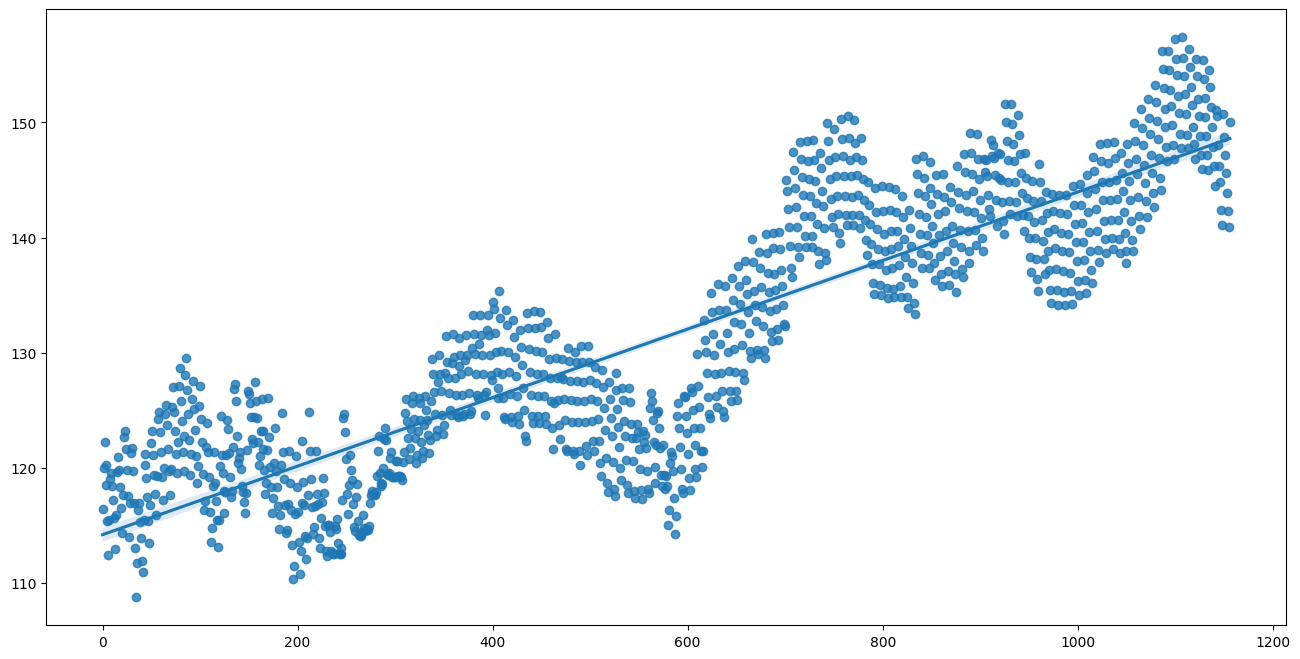

In [8]:
plt.figure(figsize=(16, 8))
sns.regplot(
    data=df_ret_o.filter(pl.col("BRAND_DESCRIPTION").is_in(major_brands))
    .group_by("PUBLISH_DATE")
    .agg(pl.col("PRODUCT_PRICE").mean())
    .with_columns(
        pl.int_range(pl.len()).alias("counter"),
    ),
    x="counter",
    y="PRODUCT_PRICE",
    robust=True,
)